In [1]:
# EXTRATROPICAL CYCLONES ANALYSIS
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from aostools import climate as ac
#from stormtrack import functions as fc
from scipy import stats

import cartopy.crs as ccrs
import matplotlib.patches as patches
import seaborn as sns

### Get data

In [2]:
# PATHS TO DATA : USER NEED TO ADJUST THESE

# path to repository
repdir='/home/561/vo7653/.local/lib/python3.9/site-packages/stormtrack/'

# path to csv files
dir1 = '/g/data/w40/vo7653/cyclones/data/surface/csv_files/'
# path to csv files of ERA5 cyclones with Tropical Cyclones (TCs)
dir2 = '/g/data/w40/vo7653/cyclones/data/surface/csv_files_with_TCs/'
# path to csv files of ERA5 cyclones withiout Tropical Cyclones (TCs) at all 
dir3 = '/g/data/w40/vo7653/cyclones/data/surface/csv_files_without_TCs/'

# path to era5 (daily)
era5_dir = '/g/data/w40/vo7653/downsized_data/ERA5/daily_data'

In [3]:
# Read csv files (pandas)

# historical
dfera = pd.read_csv(f'{dir1}no_tcERA5_cyclonetracks_cmip6_surface_historical_None_19502014_rr4.0.csv')
# Read also csv file of tracks with and without TCs for testing purposes
dfera_with_TCs = pd.read_csv(f'{dir2}ERA5_cyclonetracks_cmip6_surface_historical_None_19502014_rr4.0.csv')
dfera_without_TCs = pd.read_csv(f'{dir3}no_tropicsERA5_cyclonetracks_cmip6_surface_historical_None_19502014_rr4.0.csv')

In [ ]:
# get ERA5 daily data 

# geopotential height (Zg)
gp = xr.open_dataset(f'{era5_dir}/ERA5_dm_gp.nc', engine='netcdf4')
gp = ac.StandardGrid(gp, rename=True)
# select few pressure levels
gp = gp.sel(pres=[300,500,1000])

# IPV 350
ipv = xr.open_dataset(f'{era5_dir}/ERA5_dm_ipv350.nc', engine='netcdf4')
ipv = ac.StandardGrid(ipv, rename=True)

### Functions

##### Filtering CSV files, create gridded NETCDF files

In [5]:
def filter_features(df, L=-0.1, R1d=None, D1=None, R_InstMax=None):
    """Function for filtering extratropical cyclones according to features such as 
       Laplacian, 1-day rainfall, etc.
       INPUT:
            df – pd.df to be filtered
            L – min threshold of Laplacian -> keep cyclones with Laplacian > L
            R1d – min threshold of 1day Rainfall (pct) -> keep cyclones with Rainfall_1D > R1d
            D1 - max threshold for D1 (pct) -> keep cyclones with D1 > D1
            R_InstMax - min threshold instantaneous rainfall maximum (pct)
        OUTPUT:
            df[filtr] – filtered pd.df
    """
    
    # Filter by:
    # - - - Laplacian (~intensity) - - -
    f01 = (df['Laplacian']>=L)

    # - - - Rainfall 1D - - -
    if R1d is None:
        # not filtering by "rainy"
        filtr = f01
    else:
        # filtering "rainy" ones
        # threshold from percentile, e.g, > 95th
        print('Filtering cyclones by [Rainfall_1D]')
        print('R1d 95th pct:', df['Rainfall_1D'].quantile(R1d))
        f02 = (df['Rainfall_1D']>=df['Rainfall_1D'].quantile(R1d))
        filtr = (f01 & f02)
        
    # - - - Instantaneous Rainfall max - - -     
    if R_InstMax is None:
        filtr = filtr
    else:
        print('Filtering cyclones by [Rainfall_Inst_Max]')
        f04 = (df['Rainfall_Inst_Max']>=df['Rainfall_Inst_Max'].quantile(R_InstMax))
        filtr = (filtr & f04)
        
    # - - - Distance traveled 1D - - -  
    if D1 is None:
        # if None, you're not filtering by "not moving"
        D1 = df['D1'].values.max() + 1
        f03 = (df['D1']< D1)
    else:
        # filtering "not moving" ones; threshold from percentile, e.g. < 25th
        print('Filtering cyclones by distance travelled in 1D (not moving)...')
        print('D1 25th pct:', df['D1'].quantile(D1))
        f03 = (df['D1']< df['D1'].quantile(D1))
    
    filtr = filtr & f03

    return df[filtr]

# - - - - - - - - - - - - - - - - - - - - - - - - - -


def filter_region(df, regs, rname):
    """
        df – pd.df to be filtered, must have columns 'Lat' and "Lon'
        regs – dictionary with regions (name,area)
        rname – region name, must exist in the regions dic defined outside this func. 
    """
    
    f01 = (df['Lon'] > regs[rname]['lon'].start)
    f02 = (df['Lon'] < regs[rname]['lon'].stop)
    f03 = (df['Lat'] > regs[rname]['lat'].start)
    f04 = (df['Lat'] < regs[rname]['lat'].stop)
    
    return df[f01 & f02 & f03 & f04]

# Function to create gridded data from filtered csv files
def togrid(df_merged, T):
    """
    Steal aggregate_csv_filter.py from stormtrack repository. to get a grid
    Code from https://github.com/climatedyn/stormtrack/blob/main/aggregate_csv_filter.py
    
    df_merged : csv-file/pd.dataframe to put on a grid
    T : period for the time binning, str (e.g., 'M', '1D', '6h')
    """
    
    # Grid
    grid_size = {'Lon':5, 'Lat':5}
    
    # Define longitude and latitude bins and bin midpoints
    npoints_lon = int(360/grid_size['Lon']+1)
    npoints_lat = int(180/grid_size['Lat']+1)
    df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
    df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
    df_merged['Lon_mid'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False).apply(lambda x: (x.mid))
    df_merged['Lat_mid'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False).apply(lambda x: (x.mid))
    # Define date bin (e.g., 6 hours or 1D)
    df_merged['Date_bin'] = pd.to_datetime(df_merged['Date_Time']).dt.to_period(T).astype('str')

    # Define a subset of the data relevant for producing a binned dataset
    # Laplacian is used for initial tracking, so is probably the safest variable to use here.
    df_merged_small = df_merged[['Date_bin','Lat_mid','Lon_mid','Laplacian']]
    
    # Group by lon and lat bins, then calculate statistics
    df_merged_small = df_merged_small.groupby(['Date_bin','Lat_mid','Lon_mid'])
    df_merged_small_agg = df_merged_small.agg([len])

    # convert to Xarray
    multiind_xr_cat = fc.Agg2Xr(df_merged_small_agg)
    # ensure lat/lot are numerical and not categorical
    multiind_xr_cat['lat'] = multiind_xr_cat.lat.astype(float)
    multiind_xr_cat['lon'] = multiind_xr_cat.lon.astype(float)
    
    # divide by 4 to get units of cyclone-days
    # (4 because original dataset is 6-hourly)
    multiind_xr_cat = multiind_xr_cat/4.0

    return multiind_xr_cat

##### For plotting cyclone occurence

In [36]:
# FUNCTIONS FOR PLOTTING CYCLONES AND RELATED

# to convert longitudes
def to_lon(lonS):
    return (lonS-180)%360 - 180

def to_lonS(lon):
    return (lon + 360)%360

# draw region boxes within a plot
def draw_boxes(ax, regions, transf, color='magenta', lw=None):
    """ Draw boxes delimiting regions. """
    if lw is None:
        lw=1.2
    for region in regions.keys():
        x_min = regions[region]['lon'].start
        y_min = regions[region]['lat'].start
        wdth = regions[region]['lon'].stop - regions[region]['lon'].start
        hght = regions[region]['lat'].stop - regions[region]['lat'].start
        ax.add_patch(patches.Rectangle(xy=(to_lonS(x_min), y_min), width=wdth, height=hght, fill=False, lw=lw, color=color, transform=transf))

def get_period(da):
    "Get initial and final year of the time period of the given xr.da or xr.ds"
    year_i = da.time.min().dt.year.values
    year_f = da.time.max().dt.year.values
    return year_i, year_f

# For creating paper figures
def plot_cyclones_2(da, ttl, vmax=None, boxes=False, cb_label=False, factor_perdec=True):
    """ (*** for secondary plot!! like for other filters -> to put in the poster)
        Plot a map of cyclone frequency. Default unit is cyclone-days per decade (see togrid() function).
        INPUT:
            da : gridded data with the cyclone frequency at each grid point, xr.DataSet(time, lat, lon)
            ttl : title to add to the plot, str. E.g., 'filter 1, ERA5'
    """
    sns.set_context("notebook")
    # get number of years
    year_i = da.time.min().dt.year.values
    year_f = da.time.max().dt.year.values
    years_period = (da.time.max().dt.year - da.time.min().dt.year).values
    # factor to plot freq. per decade
    if factor_perdec is True:
        perdec = 10./years_period
    else:
        perdec = 1.
    # fig args
    coastArgs = {'color':'gray', 'linewidth':1.2}
    transf = ccrs.PlateCarree()
    fig, ax = plt.subplots(1,1, figsize=(9, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=270)})
    
    # sum over time, add dec^-1
    cm = (da.num_objs.sum('time')*perdec).plot(ax=ax, vmax=vmax, robust=True, transform=transf, add_colorbar=False)
    ax.coastlines(**coastArgs)
    if boxes is True:
        draw_boxes(ax, regions, transf, lw=2.)
    gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gls.left_labels = True
    gls.bottom_labels = True
    gls.ylabel_style = {'size': 12}
    gls.xlabel_style = {'size': 12}
    ax.set_title(f'{ttl}', fontsize=14)

    if cb_label is True:
        cb = fig.colorbar(cm, ax=ax, orientation='horizontal', extend='max', shrink=0.7, pad=0.075, aspect=22)
    else:
        cb = fig.colorbar(cm, ax=ax, orientation='horizontal', extend='max', shrink=0.7, pad=0.075)
    cb.ax.locator_params(nbins=6)
    cb.ax.tick_params(width=1.5, labelsize=12)
    if cb_label is True:
        if factor_perdec is True:
            cb.set_label(label='Frequency [cycl-days/dec]', size=12)
        else:
            cb.set_label(label='[cycl-days]', size=12)            
    return fig

# ------------------------------------------------------------------------------------------------------------


def plot_cyclones_by_seasons(da, ttl, vmax=None):
    """Same as plot_cyclones (read doc) but separating by seasons."""

    sns.set_context("notebook")
    
    # get type for title
    cycl_type = da.attrs['cyclone type'].title()
    
    # get number of years
    year_i = get_period(da)[0]
    year_f = get_period(da)[1]
    years_period = (year_f - year_i)
    # factor to plot freq. per decade
    perdec = 10./years_period
    # fig args
    coastArgs = {'color':'gray', 'linewidth':1.2}
    transf = ccrs.PlateCarree()
    
    seasons = np.array(['MAM', 'JJA', 'SON', 'DJF'])
    
    fig, axs = plt.subplots(2,2, figsize=(20, 13), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=270)})
    ac.AddPanelLabels(axs[:,:], xpos=0.01, ypos=1.02, size=20)
    #fig.suptitle(f'{ttl}', ha='center', y=0.9, fontsize=16)
    #fig.suptitle(f'{cycl_type} cyclones {ttl}', ha='center', y=0.9, fontsize=16)
    #fig.text(x=0.85, y=0.9, s=f'({year_i}-{year_f})', ha='right', fontsize=14)
    fig.subplots_adjust(wspace=0.06, hspace=0.09)

    for (s,ax) in zip(seasons, axs.flatten()):
        season_filtr = (da.time.dt.season == s).data
        var_tmp = da.isel(time=season_filtr)
         # sum over time, add dec^-1
        cm = (var_tmp.num_objs.sum('time')*perdec).plot(ax=ax, vmax=vmax, robust=True, transform=transf, add_colorbar=False)
        ax.set_title(s, fontsize=18, weight='regular')
        ax.coastlines(**coastArgs)
        gls = ax.gridlines(draw_labels=False)
        draw_boxes(ax, regions, transf, lw=1.8)
        # bottom labels
        if s in ['SON','DJF']: gls.bottom_labels = True
        # left labels
        if s in ['SON','MAM']: gls.left_labels = True
        gls.ylabel_style = {'size': 16}
        gls.xlabel_style = {'size': 16}

    cb = fig.colorbar(cm, ax=axs.ravel().tolist(), orientation='horizontal', extend='max', shrink=0.5, pad=0.04)
    cb.set_label(label='Frequency [cycl-days/dec]', size=16)
    cb.ax.tick_params(width=1.5, labelsize=16)
    return fig
    

##### For creating composites

In [6]:
def get_tsteps_regions(df, regs, in_pct=True):
    """Create a dictionary with {region (key), timesteps (value)}, where timesteps are those
        satisfying cyclone feature constraints plus within the specified region.
        It first filter by features, then by region. Then return filtered time-steps
        for each region (dictionary).
        
        INPUT:
            df : DataFrame to be filtered (e.g., ERA5 csv file)
            regs : dict of regions of interest
        OUTPUT:
            tsteps_dic : dictionary with (region_name, tsteps) pairs
    """

    tsteps_dic = {}

    # first filter stalling
    if in_pct is True:
        dff1 = filter_features(df, L=1.0, R1d=0.95, D1=0.25)
    else:
        dff1 = filter_features_abs(df, L=1.0, R1d=3.0, D1=500.)
    
    
    # second filter region
    for k,v in regs.items():

        dffr = filter_region(dff1, regs, k)

        # match ERA5 period
        dffr['Date_Time'] = pd.to_datetime(dffr['Date_Time'])
        dffr = dffr[dffr['Date_Time']>tspan.start.values]
        # get rid of hour information; match era5 time format
        tsteps = pd.to_datetime(dffr['Date_Time'], format='%Y-%m-%d %H:%M:%S').dt.floor('D').values
        # drop repetitions --> you might have several cyclone instances that date
        tsteps = np.unique(tsteps)
        # add to dic
        tsteps_dic[k] = tsteps
        # clear
        del(tsteps, dffr)
        
    return tsteps_dic

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def get_mask(tsteps_dic, timespan):
    """ Create a mask according to the timesteps (satisfying constraints) for each region. 
        Put all in one xr.DataArray with dims (time, region). Kind of an alternative to the above 
        dictionary idea... BUT!: THIS USES THE DCTIONARY CREATED BEFORE. BUT IT CAN ME MODIFIED
        IF YOU WANT TO GET RID OF THAT FIRST DIC IDEA
    INPUT:
        tsteps_dic : dictionary with (region_name, tsteps) pairs, return of the get_tsteps_region() function           
        timespan : the common timespan, as xr.da, that we want to use (e.g, timespan=gpA.time)
    OUTPUT:
        masks: xr.da(region, time), time series of True/False values saying when we have
               cyclones for that region (anywhere within).
    """

    masks = []
    # loop over regions
    for rname in tsteps_dic.keys():
        # time steps for those cyclones AND in that region
        tsteps = tsteps_dic[rname]

        # create a mask
        mask = timespan.time.isin(tsteps)
        mask['region'] = rname
        masks.append(mask)
    # concat
    masks = xr.concat(masks, dim='region')
    
    return masks


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def compose(varfield, tsteps_mask, lags=None, season=None):
    """Make composites using the filtered cyclones time steps (i.e., composites on regions)
        INPUT:
            varfield: variable field to be composited, xr.DataArray (lon,lat,time)
            tsteps_mask: time steps mask of the filtered (e.g., stalling) cyclones per region,
                          xr.DataArray(region, time). Note its time dim is the entire period
        OUTPUT:
            composites: composites of the varfield chosen (e.g, gp, cycl_freq), xr.ds with
                         dims of (lon, lat, region, lag, season)
    """
    # -------------------------
    # Reminder:
    # lags and leads analysis
    # .shift(time=delta) 
    # delta>0 --> to look at what happened before 
    # delta<0 --> to look at what happened after
     # ------------------------
    
    if lags is not None:
        # assure lag 0 is on the list
        lags = np.sort(np.unique(np.append(lags,0)))
        
    if lags is None:
        # create lags array with 0 only
        lags = np.array([0])
        
    # get number of years 
    years_period = (varfield.time.max().dt.year - varfield.time.min().dt.year).values
        
    # check what was given as varfield
    if 'num_objs' in varfield:
        # varfield is the cyclone freq map
        cycl_freqs = True
    else:
        cycl_freqs = False
  
    
    composites = []
    pvals = []
    
    # filter by season
    if season is not None:
        season_filtr = (varfield.time.dt.season == season).data
    else:
        # no sesonal filter: array of True values only
        season_filtr = np.full_like(varfield.time, True, dtype=bool)
    
    # loop over regions
    for r in tsteps_mask.region.values:
        # filter time steps for that region
        filtr = tsteps_mask.sel(region=r)
        # add seasonal filter if any
        filtr = filtr*season_filtr
        # get sample size
        N = filtr.sum()
            
        lag_composites = []
        lag_pvals = []

        # loop over lags
        for l in lags:
            # shift in time
            varfield_shifted = varfield.shift(time=-l)
            # apply time filter, time mean, get composite
            if cycl_freqs:
                # note in this case is not time mean but sum
                composite_l = varfield_shifted.num_objs.isel(time=filtr).sum('time')
            else:
                composite_l = varfield_shifted.isel(time=filtr).mean('time')
                # t-test, get p-value
                pval_l = ac.StatTest(varfield_shifted.isel(time=filtr), 0, 'T', dim='time')
                pval_l['lag'] = l
                lag_pvals.append(pval_l)     
                
            composite_l['lag'] = l
            lag_composites.append(composite_l)

        lag_composites = xr.concat(lag_composites, dim='lag')
        lag_composites['region'] = r
        lag_composites['N'] = N
        composites.append(lag_composites)
        
        if cycl_freqs is False:
            lag_pvals = xr.concat(lag_pvals, dim='lag')
            pvals.append(lag_pvals)
     
    composites = xr.concat(composites, dim='region')
    composites['season'] = season
    composites.attrs['years_period'] = years_period

    if cycl_freqs is False:
        pvals = xr.concat(pvals, dim='region')
        # merge composites and p-values
        composites = xr.merge([composites,pvals])    
    
    return composites

### Filtering ERA5 cyclone tracks

#### Stalling

In [17]:
# - - - -  ERA5 - - - - 
# Filter stalling ETCs using percentiles for thresholds, convert to grid

# define Laplacian threshold to filter for strength
L_thresh = 0.0 

dfF1 = filter_features(dfera, L=L_thresh, R1d=0.95, D1=0.25)
# convert to grid
daF1 = togrid(dfF1, '1D')
daF1.attrs['cyclone type'] = 'stalling'

# Filter stalling cyclones from tracks that keep all TCs - ERA5

dfF1_with_TCs = filter_features(dfera_with_TCs, L=L_thresh, R1d=0.95, D1=0.25)
daF1_with_TCs = togrid(dfF1_with_TCs, '1D')
daF1_with_TCs.attrs['cyclone type'] = 'stalling'

# Filter stalling cyclones from tracks with NO TCs (all removed, regardless of intensity) - ERA5

dfF1_without_TCs = filter_features(dfera_without_TCs, L=L_thresh, R1d=0.95, D1=0.25)
daF1_without_TCs = togrid(dfF1_without_TCs, '1D')
daF1_without_TCs.attrs['cyclone type'] = 'stalling'

# MATCH LENGTH OF DATASET
# cause track files are from 1949 to 2014, but ERA5 vars from 1959 to 2022

# find comon time period
min_time = max(da.time.min() for da in [gp, daF1])
max_time = min(da.time.max() for da in [gp, daF1])
tspan = slice(min_time, max_time)

daF1 = daF1.sel(time=tspan)
daF1_with_TCs = daF1_with_TCs.sel(time=tspan)
daF1_without_TCs = daF1_without_TCs.sel(time=tspan)

# number of years
years_period = (tspan.stop.dt.year - tspan.start.dt.year).values

#### Slow-movement and High-precipitation

In [14]:
daF1_without_TCs

<xarray.Dataset>
Dimensions:   (time: 5990, lat: 36, lon: 72)
Coordinates:
  * time      (time) datetime64[ns] 1950-01-04 1950-01-09 ... 2014-12-25
  * lat       (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon       (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    num_objs  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    cyclone type:  stalling

In [10]:
# Filter rainy only and slow only cyclones, independently, to compare 
# to the stalling (meeting both criteria) filter


# Rainy only
dfF1R = filter_features(dfera, L=L_thresh, R1d=0.95, D1=None)
daF1R = togrid(dfF1R, '1D')
daF1R.attrs['cyclone type'] = 'rainy'
daF1R.attrs['thresh'] = 'R1d>95th'

# Slow only
dfF1S = filter_features(dfera, L=L_thresh, R1d=None, D1=0.25)
daF1S = togrid(dfF1S, '1D')
daF1S.attrs['cyclone type'] = 'slow'
daF1S.attrs['thresh'] = 'D1<25th'

# restrict to common time period
daF1R = daF1R.sel(time=tspan)
daF1S = daF1S.sel(time=tspan)

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.2195537835359573


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 498.73113948754826


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

NameError: name 'tspan' is not defined

#### Test sensitivity to thresholds

In [9]:
# To check sensitivity to thresholds
daF1_sensitivity = []
# loop over threshold for Rain
for pct_R in [0.90, 0.95, 0.97, 0.99]:
    # for that rain pct:
    daF1_sensitivity_D = []
    # loop over threshold for Distance
    for pct_D in [0.50, 0.35, 0.25, 0.10]:
        # pd.df
        dfF1_tmp = filter_features(dfera, L=1.0, R1d=pct_R, D1=pct_D)
        # to grid, xr.da
        daF1_tmp = togrid(dfF1_tmp, '1D')
        daF1_tmp['pct_D1'] = pct_D
        daF1_sensitivity_D.append(daF1_tmp)
    # concat along distance pct
    daF1_sensitivity_D = xr.concat(daF1_sensitivity_D, dim='pct_D1')
    daF1_sensitivity_D['pct_R1d'] = pct_R
    daF1_sensitivity.append(daF1_sensitivity_D)
daF1_sensitivity = xr.concat(daF1_sensitivity, dim='pct_R1d')

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 2.5757239423692226
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 809.1277842906286


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 2.5757239423692226
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 620.5611355467807


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 2.5757239423692226
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 498.73113948754826


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 2.5757239423692226
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 303.6816201852996


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.2195537835359573
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 809.1277842906286


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.2195537835359573
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 620.5611355467807


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.2195537835359573
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 498.73113948754826


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.2195537835359573
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 303.6816201852996


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.693526484817266
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 809.1277842906286


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.693526484817266
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 620.5611355467807


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.693526484817266
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 498.73113948754826


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 3.693526484817266
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 303.6816201852996


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 4.709928077459331
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 809.1277842906286


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 4.709928077459331
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 620.5611355467807


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 4.709928077459331
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 498.73113948754826


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

Filtering cyclones by [Rainfall_1D]
R1d 95th pct: 4.709928077459331
Filtering cyclones by distance travelled in 1D (not moving)...
D1 25th pct: 303.6816201852996


/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lon_bin'] = pd.cut(df_merged['Lon'], np.linspace( 0, 360, npoints_lon), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Lat_bin'] = pd.cut(df_merged['Lat'], np.linspace(-90, 90, npoints_lat), right=False)
/jobfs/135964811.gadi-pbs/ipykernel_1479891/705224409.py:88: SettingWithCopyWarning: 
A value is trying to

In [18]:
# match comon time period
daF1_sensitivity = daF1_sensitivity.sel(time=tspan)
# sum num. of objs over time
daF1_sensitivity_objs = daF1_sensitivity.num_objs.sum('time')

### Plot cyclone occurrence globally 

In [19]:
# Plotting / Figure arguments
coastArgs = {'color':'gray', 'linewidth':1.2}
transf = ccrs.PlateCarree()

# define regions of interest (done after looking at the plots really)
regions = { 
    # NH
    'Asia': {'lon': slice(123, 150), 'lat': slice(20, 40)},
    'NorthAmerica': {'lon': slice(280, 310), 'lat': slice(25, 45)},
    # SH
    'TasmanSea': {'lon': slice(150, 175), 'lat': slice(-47, -25)},
    'SouthAmerica': {'lon': slice(303, 325), 'lat': slice(-44, -25)},
    'SouthAfrica': {'lon': slice(30, 52), 'lat': slice(-40, -23)},

}

# labels for pretty paper figures 
regions_labels = { 
        # NH
        'Asia': 'Asia',
        'NorthAmerica': 'North America',
        # SH
        'TasmanSea': 'Australia', 
        'SouthAmerica': 'South America',
        'SouthAfrica': 'Southern Africa',
        }

regsSH = {k:regions[k] for k in list(regions)[:3]}
regsNH = {k:regions[k] for k in list(regions)[3:]}

**PAPER FIG.1. Three filters: Rainy, Slow, Stalling**

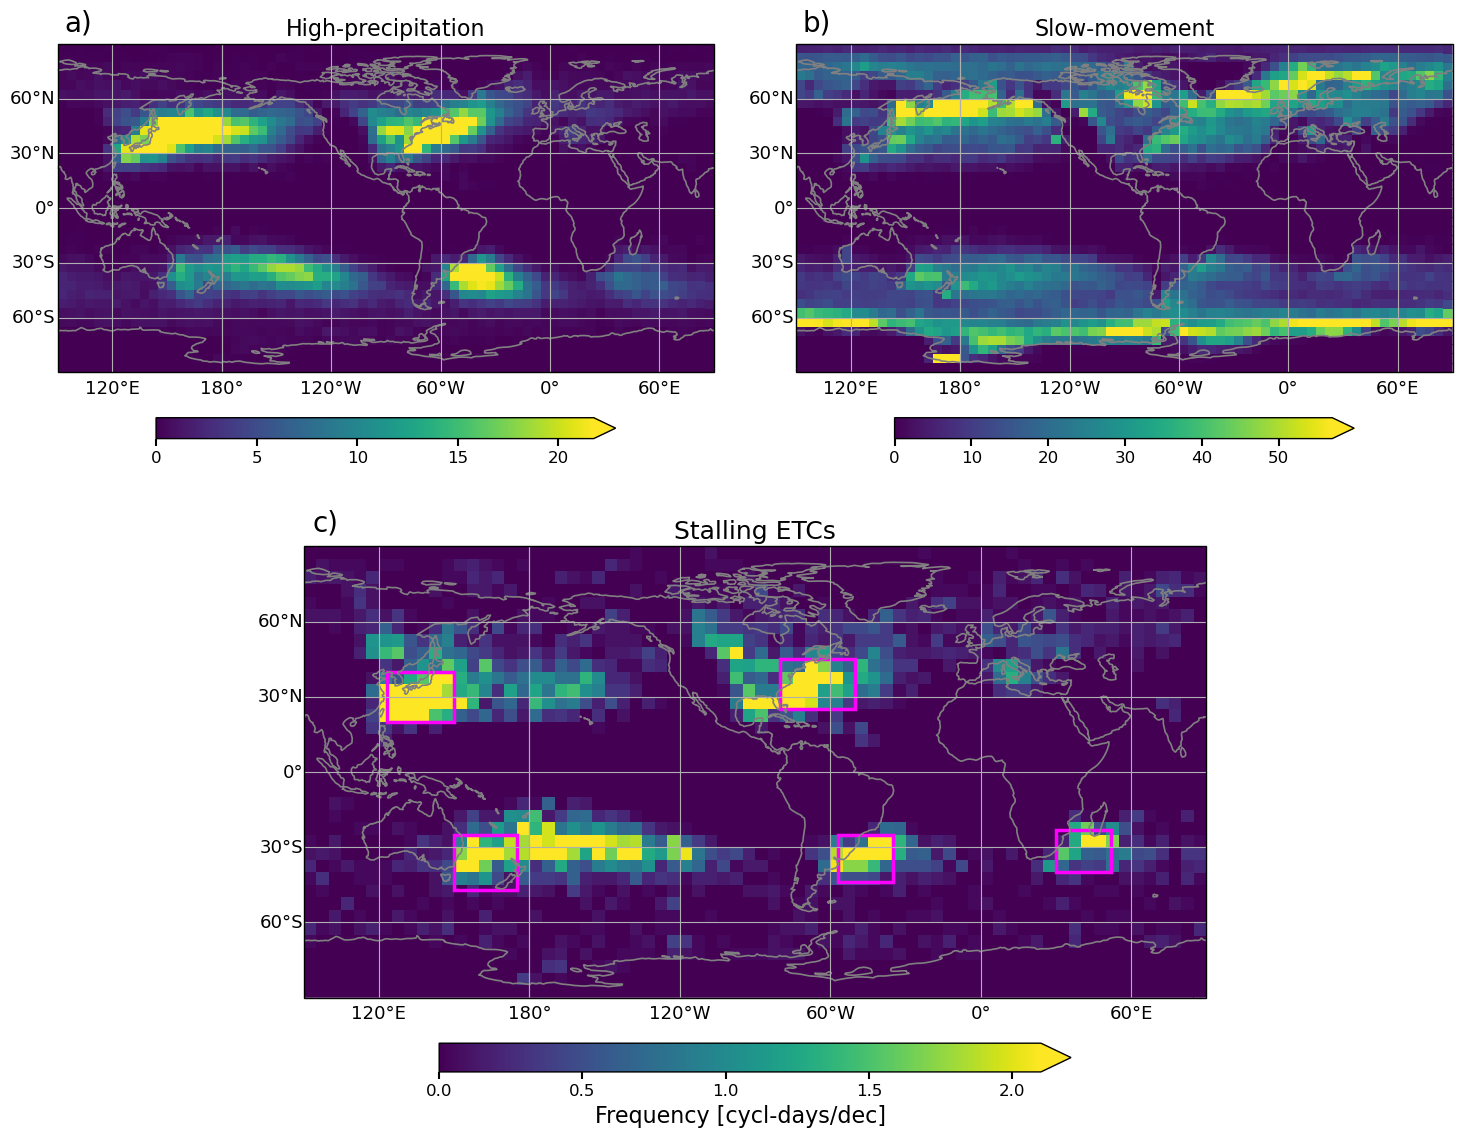

In [28]:
# Plot all filters in one figure
sns.set_context("paper")

# to make units cycl-day/dec
perdec = 10./years_period
fs = 16

# fig args
coastArgs = {'color':'gray', 'linewidth':1.2}
transf = ccrs.PlateCarree()
cb12Args = dict(orientation='horizontal', extend='max', shrink=0.7, pad=0.075, aspect=22)

fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(ncols=6, nrows=6, figure=fig)
fig.subplots_adjust(hspace=0.1, wspace=0.5)
ax1 = fig.add_subplot(gs[:3,:3], projection=ccrs.PlateCarree(central_longitude=270))  # top left
ax2 = fig.add_subplot(gs[:3,3:], projection=ccrs.PlateCarree(central_longitude=270))  # top right
ax3 = fig.add_subplot(gs[3:,1:5], projection=ccrs.PlateCarree(central_longitude=270))  # bottom
axs = [ax1, ax2, ax3]
ac.AddPanelLabels(axs, xpos=0.01, ypos=1.02, size=20)

###### TOP PANELS ########
# rainy
cm1 = (daF1R.num_objs.sum('time')*perdec).plot(ax=ax1, robust=True, transform=transf, add_colorbar=False)
ax1.set_title('High-precipitation', fontsize=fs)
cb1 = fig.colorbar(cm1, ax=ax1, **cb12Args)
# slow
cm2 = (daF1S.num_objs.sum('time')*perdec).plot(ax=ax2, robust=True, transform=transf, add_colorbar=False)
ax2.set_title('Slow-movement', fontsize=fs)
cb2 = fig.colorbar(cm2, ax=ax2, **cb12Args)

##### BOTTOM PANEL #######
# stalling
cm3 = (daF1.num_objs.sum('time')*perdec).plot(ax=ax3, robust=True, vmax=2.1, transform=transf, add_colorbar=False)
ax3.set_title('Stalling ETCs', fontsize=fs+2)
cb3 = fig.colorbar(cm3, ax=ax3, orientation='horizontal', extend='max', shrink=0.7, pad=0.075, aspect=22)
cb3.set_label(label='Frequency [cycl-days/dec]', size=16)
# add region boxes
draw_boxes(ax3, regions, transf, lw=2.5)


# for all panels
for ax in [ax1, ax2, ax3]:
    ax.coastlines(**coastArgs)
    gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gls.left_labels = True
    gls.bottom_labels = True
    gls.ylabel_style = {'size': 13}
    gls.xlabel_style = {'size': 13}
    
for cb in [cb1, cb2, cb3]:
    cb.ax.locator_params(nbins=6)
    cb.ax.tick_params(width=1.5, labelsize=12)
#fig.savefig('three_filters.png', bbox_inches='tight', facecolor='white', transparent=False)

**PAPER Extended Data Fig.2.**

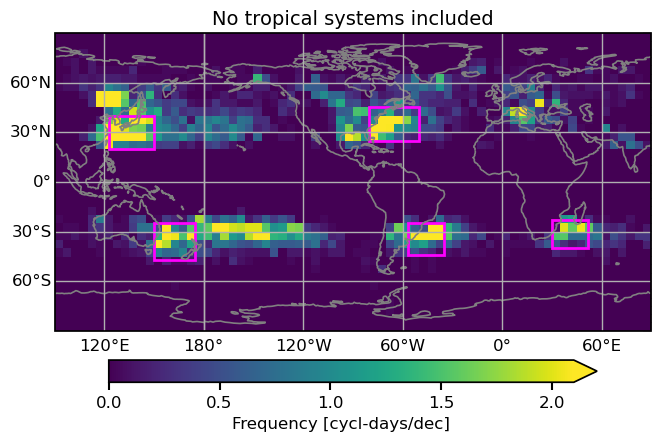

In [31]:
ttl1 = 'No tropical systems included'
fig_cycl_withoutTCs = plot_cyclones_2(daF1_without_TCs, ttl1, vmax=2.1, boxes=True, cb_label=True)
#fig_cycl_withoutTCs.savefig('No_TCs_included.png', bbox_inches='tight', facecolor='white', transparent=False)

**PAPER Extended Data Fig.3.**

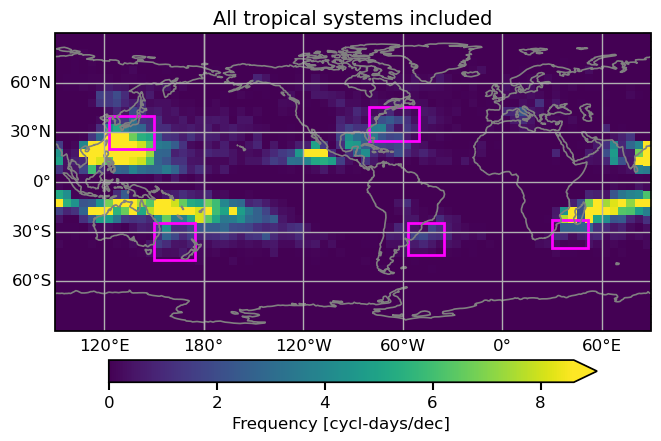

In [32]:
ttl1 = 'All tropical systems included'
fig_cycl_wTCs = plot_cyclones_2(daF1_with_TCs, ttl1, vmax=None, boxes=True, cb_label=True)
#fig_cycl_wTCs.savefig(f'All_TCs_included.png', bbox_inches='tight', facecolor='white', transparent=False)

**PAPER Extended Data Fig.4.**

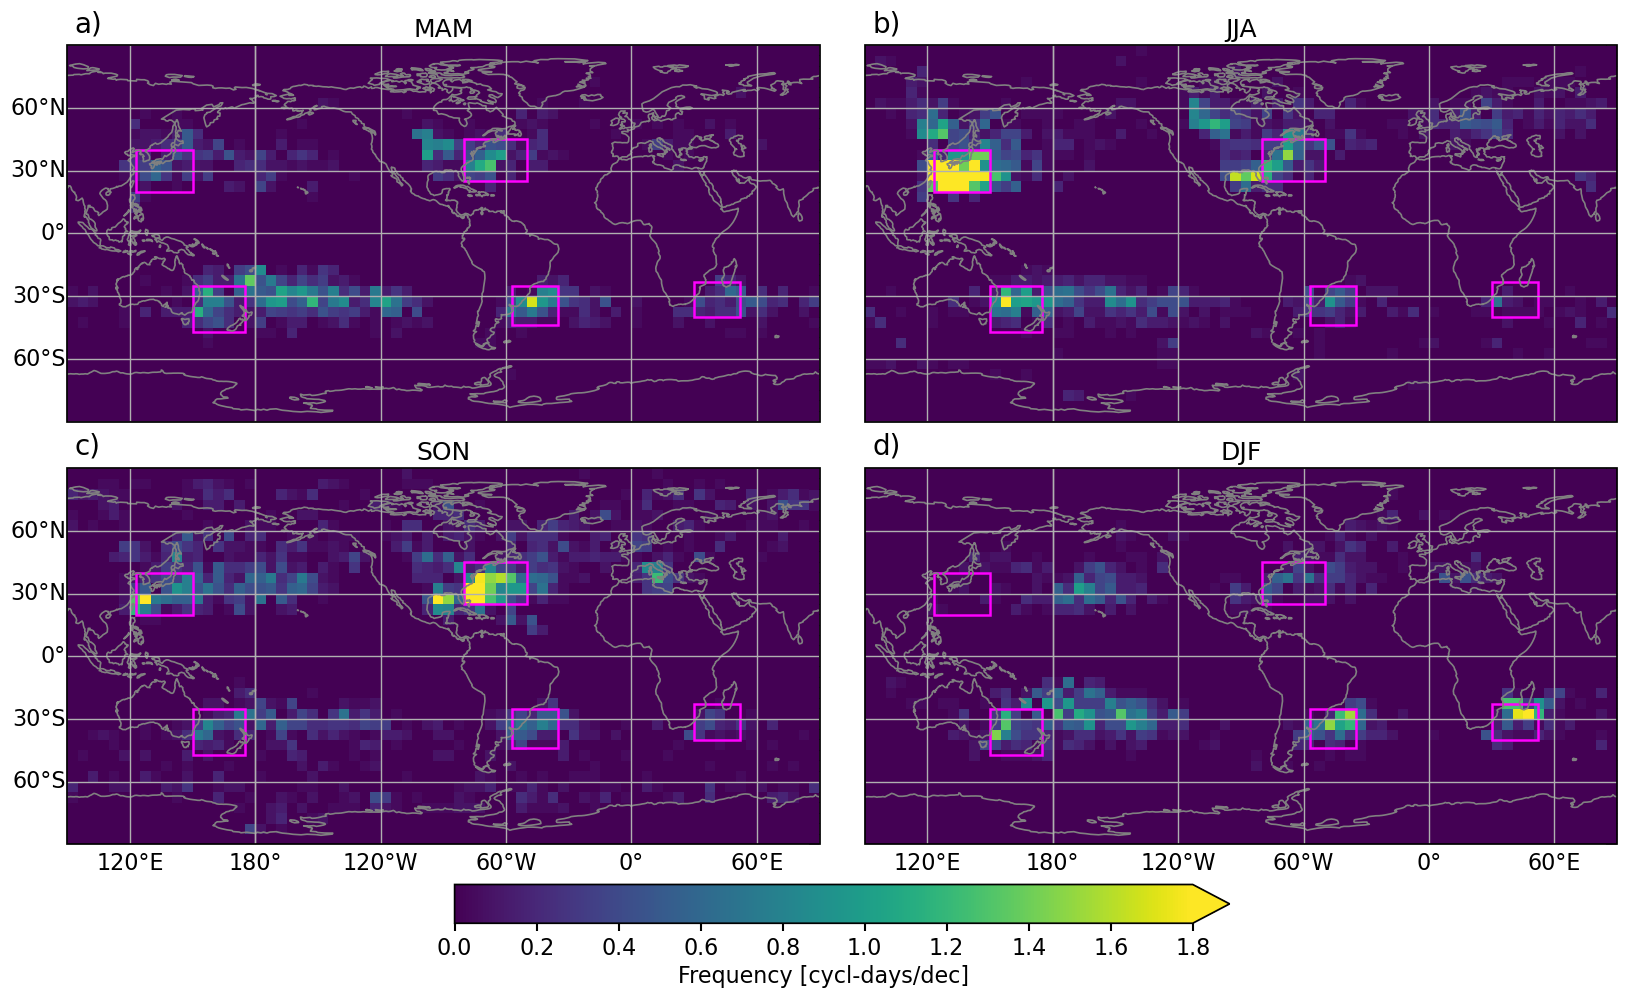

In [37]:
figseasons = plot_cyclones_by_seasons(daF1, ttl=ttl1, vmax=1.8)
#figseasons.savefig(f'stalling_by_seasons.png', bbox_inches='tight', facecolor='white', transparent=False)

**Extended Data Fig.X**

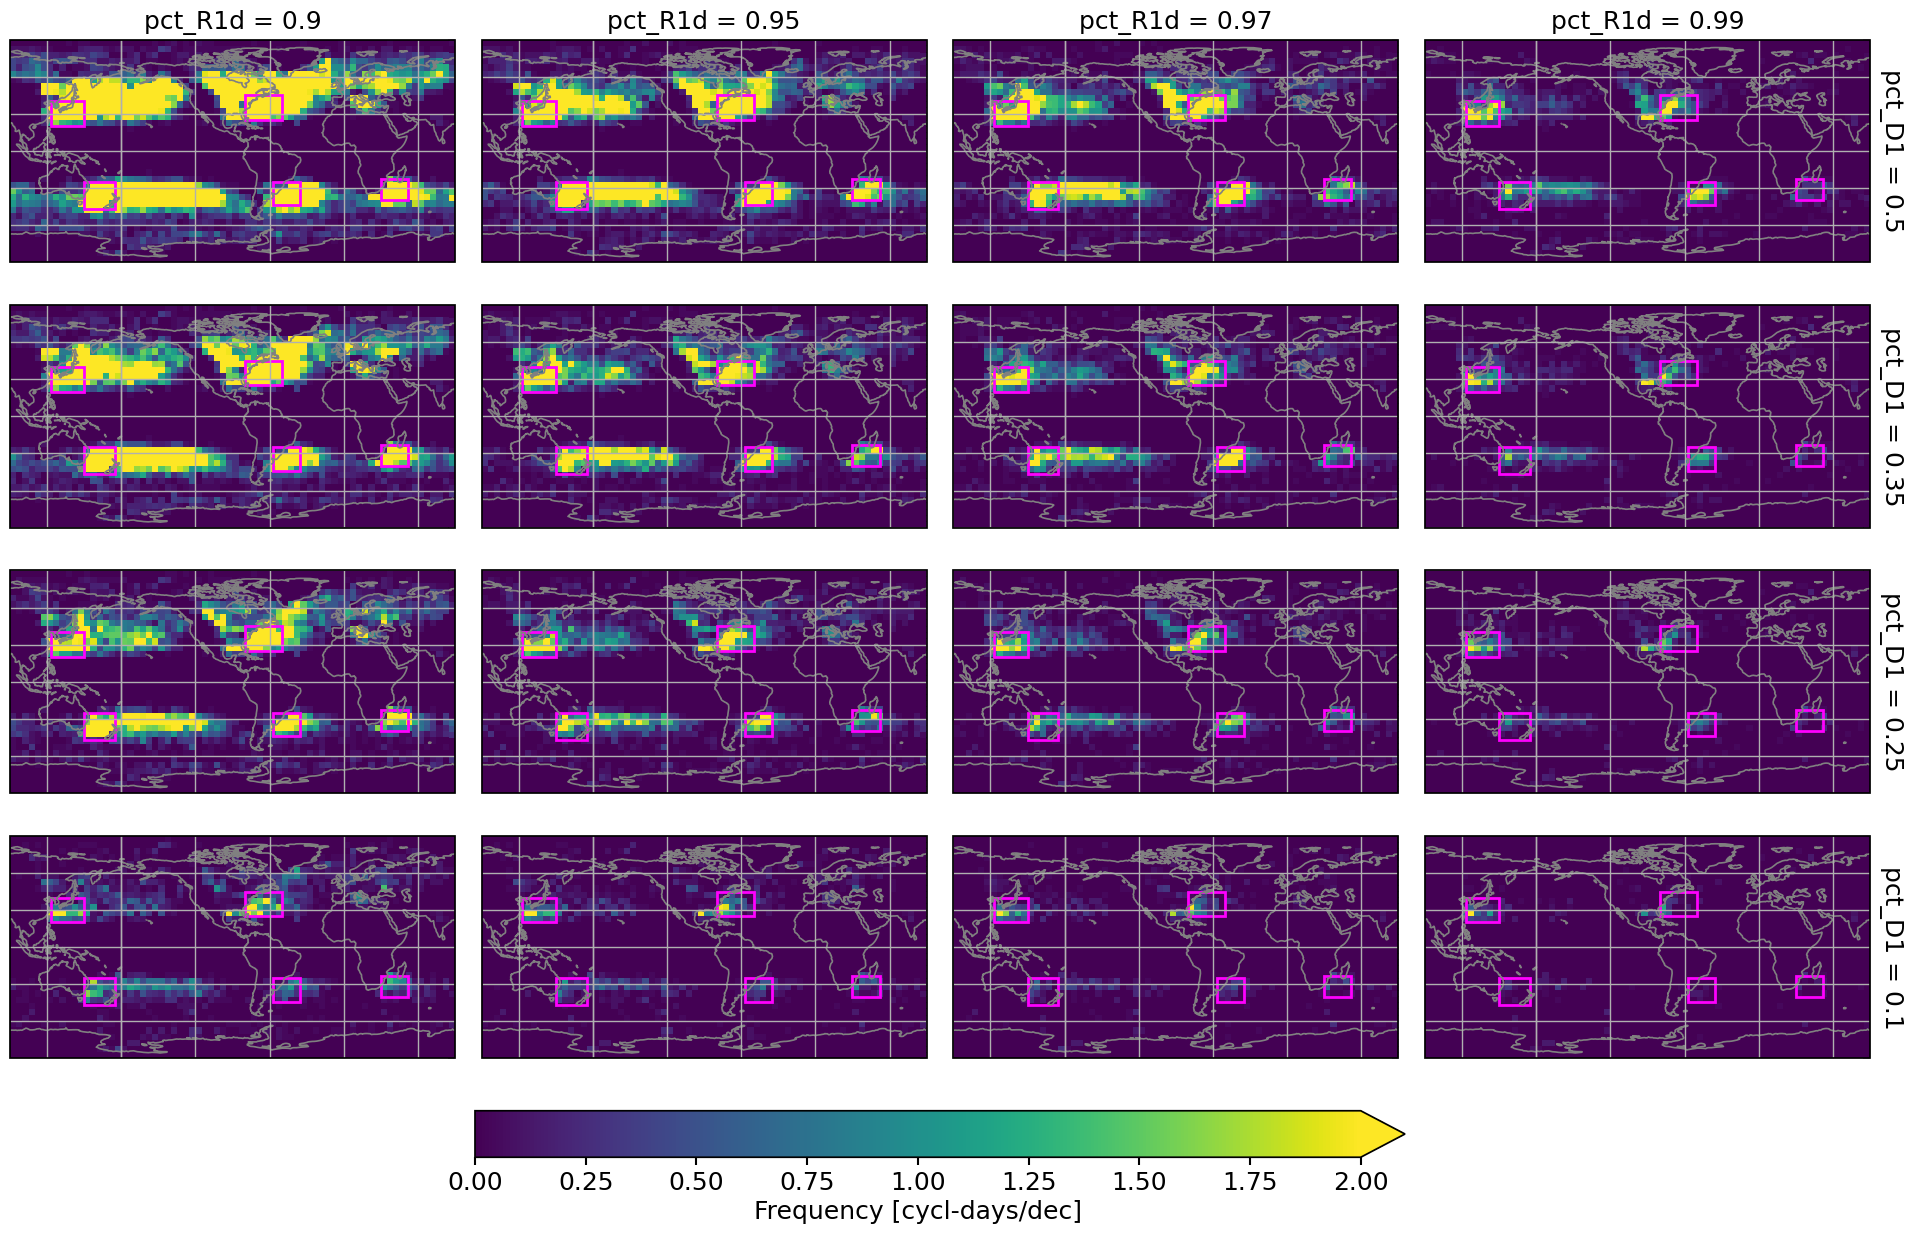

In [44]:
# PLOT SENSITIVITY TEST - VERSION WITH SUBPLOTS
  
fig, axs = plt.subplots(4,4, figsize=(24, 17), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=270)})
fig.subplots_adjust(wspace=0.06, hspace=0.005)

for row_idx, row_val in enumerate(daF1_sensitivity_objs.pct_D1):
    for col_idx, col_val in enumerate(daF1_sensitivity_objs.pct_R1d):
        ax = axs[row_idx, col_idx]
        # Get the corresponding subset of the data and plot
        subset = (daF1_sensitivity_objs.sel(pct_R1d=col_val, pct_D1=row_val))*perdec
        p = subset.plot(ax=ax, robust=True, vmax=2.0, transform=transf, add_colorbar=False, add_labels=False)
        ax.coastlines(**coastArgs)
        gls = ax.gridlines(draw_labels=False)
        draw_boxes(ax, regions, transf, lw=2.)
        col_lbl = col_val.data
        row_lbl = row_val.data
        # labels of R1d pct on the top
        if row_idx==0:
            ax.text(0.5, 1.05, f'pct_R1d = {col_lbl}', ha='center',  fontsize=18, weight='medium', transform=ax.transAxes)
        # labels of D1 pct on the right top to bottom
        if col_idx==axs.shape[1]-1:
            ax.text(1.02, 0.5, f'pct_D1 = {row_lbl}', ha='left', va='center', rotation=270, fontsize=18, weight='medium', transform=ax.transAxes)

cb = fig.colorbar(p, ax=axs.ravel().tolist(), orientation='horizontal', extend='max', shrink=0.5, pad=0.04)
cb.set_label(label='Frequency [cycl-days/dec]', size=18)
cb.ax.tick_params(width=1.5, labelsize=18)
#fig.savefig('sensitivity_test.png', bbox_inches='tight', facecolor='white', transparent=False)

## Look at atmospheric variables
Composite atmopheric variables such as Zg, V, etc., using storm-based filtered timesteps

In [ ]:
# Select common time period, in case they don't have the same
gp = gp.sel(time=tspan)
ipv = ipv.sel(time=tspan)

# Compute anomalies wrt day-of-year
groupby = 'time.dayofyear'
gp_anom = gp.groupby(groupby) - gp.groupby(groupby).mean('time')
ipv_anom = ipv.groupby(groupby) - ipv.groupby(groupby).mean('time')

# This is needed first
tsteps_dic_era5 = get_tsteps_regions(dfera, regions, in_pct=True)
mask_era5 = get_mask(tsteps_dic_era5, timespan=gp_anom.time)

# Geopotential
gp_comp = []  
#lags = np.arange(-10,11,2)
lags = np.arange(-1,1,1)
for s in [None]:#['MAM', 'JJA', 'SON', 'DJF', None]:
    comp = compose(gp_anom.sel(pres=500).z, mask_era5, lags=lags, season=s)
    gp_comp.append(comp)
gp_comp = xr.concat(gp_comp, dim='season')

# IPV-350K
ipv_comp = []  
lags = np.arange(-1,1,1)
for s in [None]: #['MAM', 'JJA', 'SON', 'DJF', None]:
    comp = compose(ipv_anom.ipv, mask_era5, lags=lags, season=s)
    ipv_comp.append(comp)
ipv_comp = xr.concat(ipv_comp, dim='season')

### Plot composites

**PAPER FIG.2**

Geopotential at 500-hPa

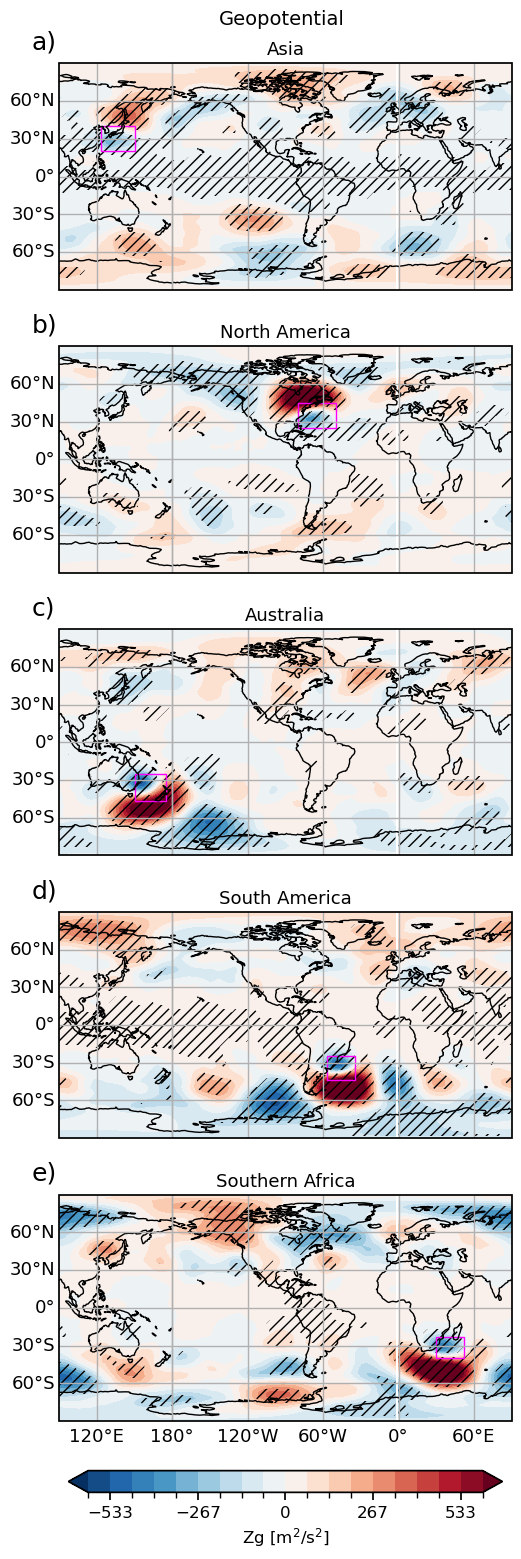

In [46]:
# Geopotential Height with SIGNIFICANCE (HATCHING)

fs_region = 13
# plot from composite variable
var = gp_comp.sel(lag=0, season=None)
# show significance
sig_mask = var.pval < 0.05

lats = sig_mask.lat
lons = sig_mask.lon
transf = ccrs.PlateCarree()

# contour leveles
clevs = np.linspace(-600, 600, 19) 
figArgs = {'levels':clevs, 'robust':False, 'transform':transf, 'add_colorbar':False, 'extend':'both'}
fig, axs = plt.subplots(5,1, figsize=(14, 4.3*5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=270)})
ac.AddPanelLabels(axs[:], xpos=-0.06, ypos=1.04, size=18)
fig.suptitle('Geopotential', x=0.51, y=0.905, fontsize=14)
fig.subplots_adjust(hspace=0.25)
for rname,ax in zip(regions.keys(), axs.flatten()):  
    # var to plot
    var1 = var.sel(region=rname).z
    cf = var1.plot.contourf(ax=ax, **figArgs)
    # Overlay hatching on significant regions
    ax.contourf(lons, lats, sig_mask.sel(region=rname), levels=[0,0.9,1.2], colors='none', hatches=['', '///'], alpha=0, transform=transf)
    
    ax.set_title(f'{regions_labels[rname]}', fontsize=fs_region)
    ax.coastlines()
    gls = ax.gridlines(crs=ccrs.PlateCarree())
    gls.left_labels = True
    gls.ylabel_style = {'size': 13}#, 'color': 'blue', 'weight': 'bold', 'rotation': 0}
    gls.xlabel_style = {'size': 13}
    if rname == 'SouthAfrica':
        gls.bottom_labels = True
    del(var1)
    draw_boxes(ax, {rname: regions[rname]}, transf, lw=1.0)

cb = fig.colorbar(cf, ax=axs.ravel().tolist(), orientation='horizontal', extend='both', shrink=0.4, pad=0.03)
cb.set_label(label='Zg [m$^2$/s$^2$]', size=12)
cb.ax.locator_params(nbins=6)
cb.ax.tick_params(labelsize=12)
#fig.savefig(f'gp_sig95.png', bbox_inches='tight', facecolor='white', transparent=False)

**PAPER Extended Data Fig.4.**

Isentropic Potential Vorticity at 350K

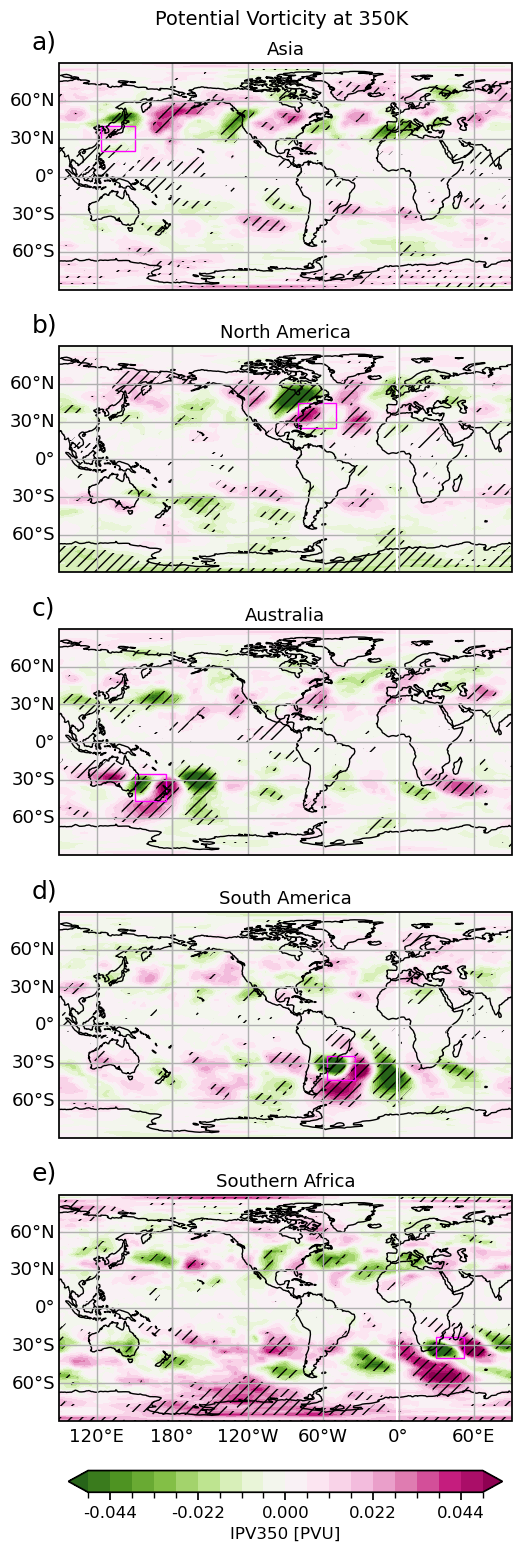

In [47]:
# IPV 350K with SIGNIFICANCE
from matplotlib.ticker import FormatStrFormatter

# PV Units (PVU) factor
PVU1 = 10e-6  # K m^2 kg^-1 s^-1
# plot from composite variable
var = ipv_comp.sel(lag=0, season=None)
# show significance
sig_mask = var.pval < 0.05

lats = sig_mask.lat
lons = sig_mask.lon
transf = ccrs.PlateCarree()
cmap = 'PiYG_r'

# contour leveles
clevs = np.linspace(-0.05, 0.05, 19)
figArgs = {'levels':clevs, 'robust':False, 'transform':transf, 'add_colorbar':False, 'cmap':cmap, 'extend':'both'}
fig, axs = plt.subplots(5,1, figsize=(14, 4.3*5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=270)})
ac.AddPanelLabels(axs[:], xpos=-0.06, ypos=1.04, size=18)
fig.suptitle('Potential Vorticity at 350K', x=0.51, y=0.905, fontsize=14)
fig.subplots_adjust(hspace=0.25)
for rname,ax in zip(regions.keys(), axs.flatten()):  
    # var to plot
    var1 = var.sel(region=rname).ipv / PVU1
    cf = var1.plot.contourf(ax=ax, **figArgs)
    # Overlay hatching on significant regions
    ax.contourf(lons, lats, sig_mask.sel(region=rname), levels=[0,0.9,1.2], colors='none', hatches=['', '///'], alpha=0, transform=transf)
    
    ax.set_title(f'{regions_labels[rname]}', fontsize=fs_region)
    ax.coastlines()
    gls = ax.gridlines(crs=ccrs.PlateCarree())
    gls.left_labels = True
    gls.ylabel_style = {'size': 13}#, 'color': 'blue', 'weight': 'bold', 'rotation': 0}
    gls.xlabel_style = {'size': 13}
    if rname == 'SouthAfrica':
        gls.bottom_labels = True
    del(var1)
    draw_boxes(ax, {rname: regions[rname]}, transf, lw=1.0)

cb = fig.colorbar(cf, ax=axs.ravel().tolist(), orientation='horizontal', extend='both', shrink=0.4, pad=0.03)
cb.set_label(label='IPV350 [PVU]', size=12)
cb.ax.locator_params(nbins=6)
cb.ax.tick_params(labelsize=12)
# Set the tick labels format to show desired decimal places
cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#fig.savefig('ipv350_sig95.png', bbox_inches='tight', facecolor='white', transparent=False)